# EEE 197z Project 1 - Zero Shot Object Detection
use SAM to perform zero-shot object detection using COCO 2017 val split. 

*Author: Sean Red Mendoza | 2020-01751 | scmendoza5@up.edu.ph*

## Tools/ References
- [SegmentAnything](https://github.com/facebookresearch/segment-anything)
- [OpenClip](https://github.com/mlfoundations/open_clip)
- [Coco 2017 Validation Dataset](https://cocodataset.org/#home)
- [roatienza/mlops](https://github.com/roatienza/mlops)
- [roatienza/Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments)
- [Google Cloud G2 GPU VM (Nvidia L4)](https://cloud.google.com/blog/products/compute/introducing-g2-vms-with-nvidia-l4-gpus)

## Goals

## Approach

## Notes


In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import torch
import torchvision
import sys
from skimage import io
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os
import open_clip
from PIL import Image
from pprint import pprint
import json
import shutil
import re

In [2]:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
print("[setup]: determining CUDA support...")
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

[setup]: determining CUDA support...
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


In [3]:
# clean output directory
if not os.path.exists("../output"):
    os.mkdir(f"../output")
shutil.rmtree("../output/")
os.mkdir(f"../output/")

## Images
This program supports manual entry of input image links or random sampling from the CoCo 2017 Validation Dataset
*Please select your desired input method below:*

- [1] Input Images
- [2] CoCo Images

After selecting the input image source, you will be asked to input the following:
- [a] List of image URL strings, or
- [b] number of random images sourced from CoCo 2017*

**a hard limit of 10 images is set to prevent overloading of the system*

In [4]:
def get_valid_input():
    while True:
        user_input = input("Enter 1 or 2: ")
        if user_input in ['1', '2']:
            return int(user_input)
        else:
            print("Invalid input. Please enter 1 or 2.")
            
def get_valid_number(n):
    while True:
        user_input = input("Enter an integer from 1 to {}: ".format(n))
        if user_input.isdigit():
            number = int(user_input)
            if 1 <= number <= n:
                return number
        print("Invalid input. Please enter an integer from 1 to {}.".format(n))

# input_type = get_valid_input()
input_type = 1

if input_type == 1:
    input_mode = "manual"
    print("You have selected MANUAL_INPUT, please enter the image URLs in the following block")
elif input_type==2:
    input_mode = "random"
    input_image_count = get_valid_number(10)
    print(f"You have selected RANDOM_INPUT of {input_image_count} images from the CoCo 2017 dataset")

You have selected MANUAL_INPUT, please enter the image URLs in the following block


In [5]:

print("[0]: loading coco annotations and captions...")
dataDir = '../coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)
# initialize COCO api for instance annotations + COCO ground truth api
cocoGt = COCO(annFile)
annFile = '{}/annotations/captions_{}.json'.format(dataDir, dataType)
coco_caps = COCO(annFile)
catIDs = cocoGt.getCatIds()

# get all captions
annIds = coco_caps.getAnnIds(imgIds=[], catIds=[])
anns = coco_caps.loadAnns(annIds)
coco_labels_words = []
for ann in anns:
    words = ann['caption'].split()
    for word in words:
        clean_word = re.sub(r'[^a-zA-Z0-9\s]', '', word.lower())
        coco_labels_words.append(clean_word)

coco_labels_words_values = list(set(coco_labels_words))

[0]: loading coco annotations and captions...
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [6]:
input_image_IDs = []
input_image_catIDs = []
input_images_links = []
input_image_areas = []
input_image_labels = []

## RANDOM INPUT
def get_random_coco_image(n):
    for i in range(n):
        # get random coco image
        catID = catIDs[np.random.randint(0, len(catIDs))]
        catImages = cocoGt.getImgIds(catIds=[catID])
        imgID = catImages[np.random.randint(0, len(catImages))]
        # build image meta data
        img = cocoGt.loadImgs(imgID)[0]
        imgArea = img['height']*img['width']
        imgURL = img['coco_url']
        # fetch ground truth labels from coco
        annIds = coco_caps.getAnnIds(imgIds=imgID)
        anns = coco_caps.loadAnns(annIds)
        ground_truth_labels = list(map(lambda x: x['caption'], anns))
        input_image_IDs.append(imgID)
        input_image_catIDs.append(catID)
        input_images_links.append(imgURL)
        input_image_areas.append(imgArea)
        input_image_labels.append(ground_truth_labels)

if input_type == 2:
    random_images = get_random_coco_image(input_image_count)    

## MODIFY FOR MANUAL INPUT
if input_type == 1:
    input_images_links = ['../images/dog_car.jpg']

In [7]:
coco_results = []
label_results = []
top_one_scores = []
top_five_scores = []

In [8]:
print("[1]: loading sam model")
sam_checkpoint = os.path.join("../checkpoints", "sam_vit_h_4b8939.pth")
model_type = "vit_h"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    box_nms_thresh=0.3,
    stability_score_thresh=0.9,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

[1]: loading sam model


In [9]:
print("[2]: creating open clip model...")
modelType = 'ViT-B-32-quickgelu'
modelDataset = "laion400m_e31"
model, _, preprocess = open_clip.create_model_and_transforms(
    modelType, pretrained=modelDataset)
tokenizer = open_clip.get_tokenizer(modelType)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("[2]: loading coco categories as labels...")
text = tokenizer(coco_labels_words_values)
text = text.to(device)

[2]: creating open clip model...
[2]: loading coco categories as labels...


In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def generate_masks(image,image_index,raw_masks, area):
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    filtered_masks = []
    for i in range(length):
        mask = sorted_anns[i]
        if (mask['area'] < area):
            continue
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/{image_index}/mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1
        filtered_masks.append(mask)
    return filtered_masks


def generate_labels(anns, image_index, imgID="None", catID="None"):
    if len(anns) == 0:
        return
    length = len(anns)
    values = []
    for i in range(length):
        mask = anns[i]
        im = Image.open(f"../output/{image_index}/mask-{i+1}.jpg").convert("RGB")
        img = preprocess(im).unsqueeze(0)
        img = img.to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(img)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @
                          text_features.T).softmax(dim=-1)

        text_prob = np.max(text_probs.cpu().numpy())
        index = np.argmax(text_probs.cpu().numpy())
        label = coco_labels_words_values[index]

        print(f"[{i+1}/{length}]:",  label, f"({text_prob*100:.2f}%)",)
        values.append(
            {"label": label, "area": mask["area"], "prob": text_prob})
        result = {'image_id': imgID, 'category_id': catID,
                  "bbox": mask['bbox'], "score": mask['predicted_iou']}
        coco_results.append(result)

    # generate top 5 labels according to label_accuracy and mask_area
    sorted_values = sorted(values, key=lambda x: x['prob'])
    payload = sorted_values[:5]
    labels = list(map(lambda d: d['label'], payload))
    return labels

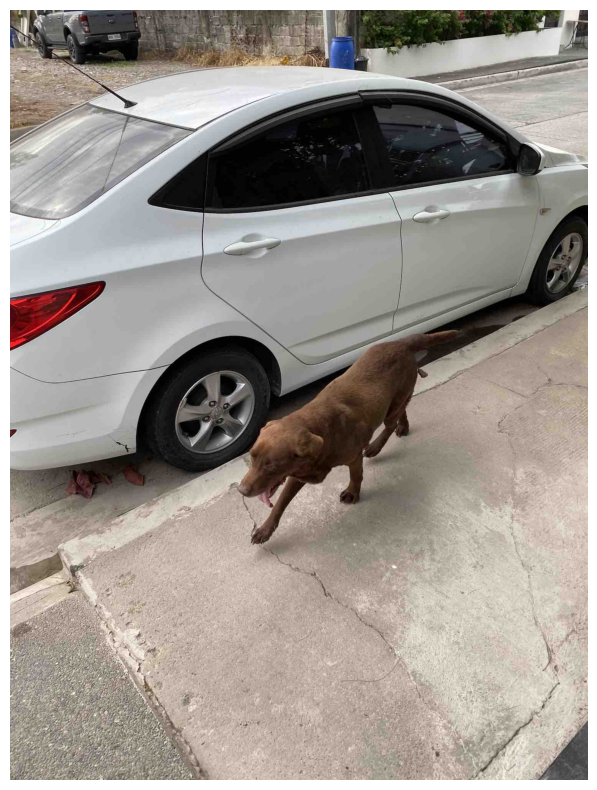

In [13]:
for image_index in range(len(input_images_links)):
    image_link = input_images_links[image_index]
    # create output folder for this image
    
    image_folder_path = f"../output/{image_index}"
    if not os.path.exists(image_folder_path):
        os.mkdir(image_folder_path)
    
    image = io.imread(image_link)
    height, width = image.shape[:2]
    imageArea = height * width
    maskArea = 0.04 * imageArea
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f"../output/{image_index}/source.jpg",
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
    raw_masks = mask_generator.generate(image)
    print(f"({image_index}): generated {len(raw_masks)} masks...")
    filtered_masks = generate_masks(image, image_index, raw_masks, maskArea)
    print(f"({image_index}): masks filtered down to {len(filtered_masks)} masks...")

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_anns(filtered_masks)
    plt.axis('off')
    plt.savefig(f"../output/{image_index}/generated-masks.jpg",
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
    source_image = io.imread(f"../output/{image_index}/source.jpg")
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(source_image, cmap='gray')
    axs[0].set_title('Source Image')
    masked_image = io.imread(f"../output/{image_index}/generated-masks.jpg")
    axs[1].imshow(masked_image, cmap='gray')
    axs[1].set_title('Image with Masks')
    plt.subplots_adjust(wspace=0.4)
    plt.show()

    
    # for each mask image, annotate using open-clip
    print(f"({image_index}): generating labels...")
    generated_labels = generate_labels(filtered_masks, image_index, imgID, catID)
    print("GENERATED LABELS")
    pprint(generated_labels)
    print("GROUND TRUTH LABELS")
    ground_truth_labels = []
    pprint(ground_truth_labels)
    ground_truth_string = " ".join(ground_truth_labels)
    
    